In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from LQN_utils_state_save_parallel import *
import itertools
from copy import deepcopy 
import sympy as sp
from itertools import groupby

In [4]:
import networkx as nx
import igraph as ig
import itertools
import hashlib

# EPM bipartite graph 생성 함수
def EPM_bipartite_graph_generator_old(num_system, num_ancilla, type): 
    results = []  # 결과 저장 리스트
    num_total = num_system + num_ancilla

    # red-blue 조합 생성 (type=0 가정)
    red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    # ancilla 조합 생성
    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                # red-blue 엣지 추가
                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]

                    B.add_edge(rb_index, red, weight=1.0)
                    B.add_edge(rb_index, blue, weight=2.0)

                    mapping[rb_index] = 'S_' + str(rb_index)
                    mapping[num_total + rb_index] = rb_index

                # ancilla 엣지 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3) 

                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = num_system + anc_index

                # 노드 속성 추가
                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                B = nx.relabel_nodes(B, mapping)  # 노드 이름 변경

                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    results.append(B)
        else:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.0)
                B.add_edge(rb_index, blue, weight=2.0)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = rb_index

            for node_index in range(2 * num_total):
                if node_index < num_system:
                    B.nodes[node_index]['category'] = 'system_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                elif node_index < num_total:
                    B.nodes[node_index]['category'] = 'ancilla_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                else:
                    B.nodes[node_index]['category'] = 'sculpting_nodes'
                    B.nodes[node_index]['bipartite'] = 1

            B = nx.relabel_nodes(B, mapping)

            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                results.append(B)

    return results  # 최종 결과 반환

# NetworkX -> iGraph 변환
def nx_to_igraph(nx_graph):
    # 노드 매핑 (문자열 → 정수 변환)
    node_map = {node: idx for idx, node in enumerate(nx_graph.nodes)}

    # 엣지 추출
    edges = []
    for u, v in nx_graph.edges():
        edges.append((node_map[u], node_map[v]))  # 정수 인덱스로 변환된 엣지 추가

    # iGraph 객체 생성
    ig_graph = ig.Graph()
    ig_graph.add_vertices(len(node_map))  # 노드 추가
    ig_graph.add_edges(edges)  # 엣지 추가
    return ig_graph

# Canonical Form 생성 (가중치를 고려하지 않음)
def canonical_form_without_weights(ig_graph):
    # iGraph의 canonical_permutation을 사용하여 가중치 없이 처리
    perm = ig_graph.canonical_permutation()  # 색상(color) 정보 없이 permutation 생성
    permuted = ig_graph.permute_vertices(perm)  # 정렬 적용
    return tuple(map(tuple, permuted.get_adjacency().data))  # Immutable 변환

# Canonical Form의 해시 생성
def generate_hash_from_canonical_form(canonical_form):
    # Canonical Form을 문자열로 변환한 뒤 해시값 생성
    canonical_str = str(canonical_form)
    return hashlib.sha256(canonical_str.encode('utf-8')).hexdigest()

# 그래프 리스트 처리 및 그룹화
def process_and_group_by_canonical_form(graph_list):
    canonical_groups = {}  # 해시 값을 키로, 그래프 그룹을 값으로 저장
    for graph in graph_list:
        # NetworkX -> iGraph 변환
        ig_graph = nx_to_igraph(graph)
        # Canonical Form 생성 (가중치 고려 안 함)
        canonical_form = canonical_form_without_weights(ig_graph)
        # Canonical Form의 해시 생성
        canonical_hash = generate_hash_from_canonical_form(canonical_form)
        # 동일 해시 값끼리 그룹화
        if canonical_hash not in canonical_groups:
            canonical_groups[canonical_hash] = []  # 새로운 그룹 생성
        canonical_groups[canonical_hash].append(graph)  # 그래프 추가
    return canonical_groups  # 그룹화된 결과 반환

In [5]:
graph_list = EPM_bipartite_graph_generator_old(num_system=3, num_ancilla=1, type=0)

In [6]:
len(graph_list)

3264

In [7]:
# 그룹화 실행
grouped_graphs = process_and_group_by_canonical_form(graph_list)

In [8]:
list(grouped_graphs.keys())[0]

'7556b192af1c6c2dd51b84b74ada0e83a43b501c40501cfa8ed7d1f385599ce0'

In [9]:
grouped_graphs[list(grouped_graphs.keys())[0]][0]

In [10]:
nx.to_numpy_array(grouped_graphs[list(grouped_graphs.keys())[0]][0])

array([[0., 0., 0., 0., 1., 2., 0., 0.],
       [0., 0., 0., 0., 1., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 2.],
       [0., 0., 0., 0., 0., 0., 3., 3.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [2., 2., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 3., 0., 0., 0., 0.],
       [0., 0., 2., 3., 0., 0., 0., 0.]])

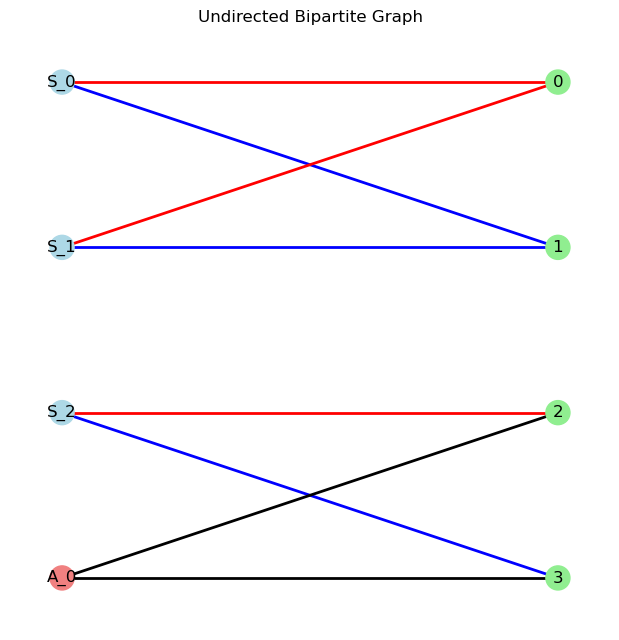

In [11]:
Draw_EPM_bipartite_graph(grouped_graphs[list(grouped_graphs.keys())[0]][0])

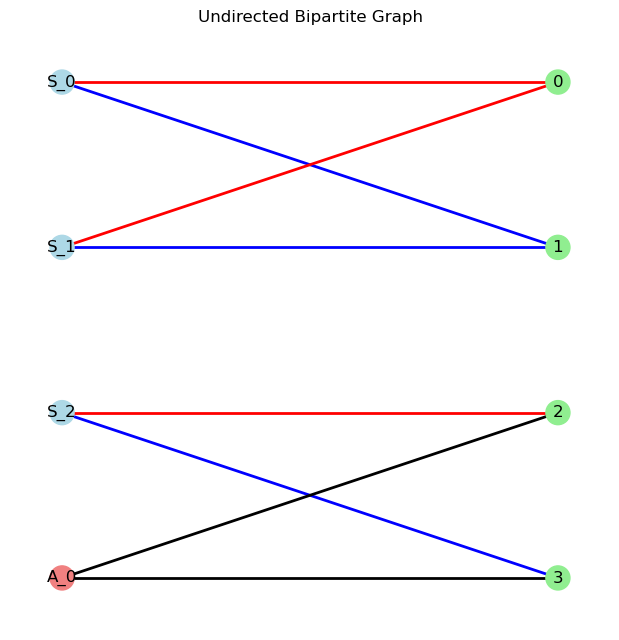

In [12]:
Draw_EPM_bipartite_graph(graph_list[0])

In [13]:
def get_adjacency_matrices(B):
    # Separate nodes by categories
    system_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'system_nodes']
    ancilla_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'ancilla_nodes']
    sculpting_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'sculpting_nodes']
    
    # Combine the nodes in the desired order
    sorted_nodes = system_nodes + ancilla_nodes + sculpting_nodes

    # Adjacency matrix (unweighted)
    #adjacency_matrix = nx.to_numpy_array(B, nodelist=sorted_nodes)

    # Weighted adjacency matrix
    weighted_adj_matrix = nx.to_numpy_array(B, nodelist=sorted_nodes, weight='weight')

    return weighted_adj_matrix



In [14]:
a = get_adjacency_matrices(graph_list[0])

In [15]:
a

array([[0., 0., 0., 0., 1., 2., 0., 0.],
       [0., 0., 0., 0., 1., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 2.],
       [0., 0., 0., 0., 0., 0., 3., 3.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [2., 2., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 3., 0., 0., 0., 0.],
       [0., 0., 2., 3., 0., 0., 0., 0.]])

In [16]:
num_total = 4

In [17]:
len(grouped_graphs)

8

In [18]:
list(grouped_graphs.keys())

['7556b192af1c6c2dd51b84b74ada0e83a43b501c40501cfa8ed7d1f385599ce0',
 '7557ff98f0fb1f45bff4842b435377aa9662820516e3f21f50807ee05670ab2e',
 '36019ea344ba82e088903dc9c14930cdd02310afc42538024b1a6bc35a3336ac',
 '218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8',
 'a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a',
 '7959e8b9b6367ea841c063652027ca3291a2759513b05897bde6c9a55b5a0d2d',
 'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d',
 '0bd32b8e4d20824cbd28a77b586a28f3476cd8be323a986e5039a815fe05c0ac']

In [19]:
list(grouped_graphs.keys())[0]

'7556b192af1c6c2dd51b84b74ada0e83a43b501c40501cfa8ed7d1f385599ce0'

In [20]:
len(grouped_graphs[list(grouped_graphs.keys())[7]])

576

In [21]:
grouped_graphs[list(grouped_graphs.keys())[7]][0]

In [22]:
def EPM_digraph_from_EPM_bipartite_graph(B):
    """
    Convert an EPM bipartite graph (B) to a directed graph (D).

    Parameters:
        B (nx.Graph): Input bipartite graph.

    Returns:
        nx.DiGraph: Directed graph derived from the input bipartite graph.
    """
    # Initialize directed graph
    D = nx.DiGraph()

    # Identify system and ancilla nodes
    system_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'system_nodes']
    ancilla_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'ancilla_nodes']
    num_system = len(system_nodes)
    num_ancilla = len(ancilla_nodes)
    num_total = num_system + num_ancilla

    # Generate adjacency matrix and weight matrix from B
    adj_weight_matrix_B = get_adjacency_matrices(B)

    # Extract relevant submatrices for the directed graph
    # adj_matrix_D = adj_matrix_B[:num_total, num_total:]
    adj_weight_matrix_D = adj_weight_matrix_B[:num_total, num_total:]

    # Add nodes to directed graph
    D.add_nodes_from(range(num_total))

    # Add directed edges with weights
    for i in range(num_total):
        for j in range(num_total):
            if adj_weight_matrix_D[i, j] != 0:
                D.add_edge(j, i, weight=adj_weight_matrix_D[i, j])  # Reverse direction

    # Map node labels and categories
    mapping = {}
    for i in range(num_total):
        if i < num_system:
            mapping[i] = 'S_' + str(i)
            D.nodes[i]['category'] = 'system_nodes'
        else:
            mapping[i] = 'A_' + str(i - num_system)
            D.nodes[i]['category'] = 'ancilla_nodes'

    # Relabel nodes
    D = nx.relabel_nodes(D, mapping)

    return D


In [23]:
D = EPM_digraph_from_EPM_bipartite_graph(graph_list[0])

In [24]:
D

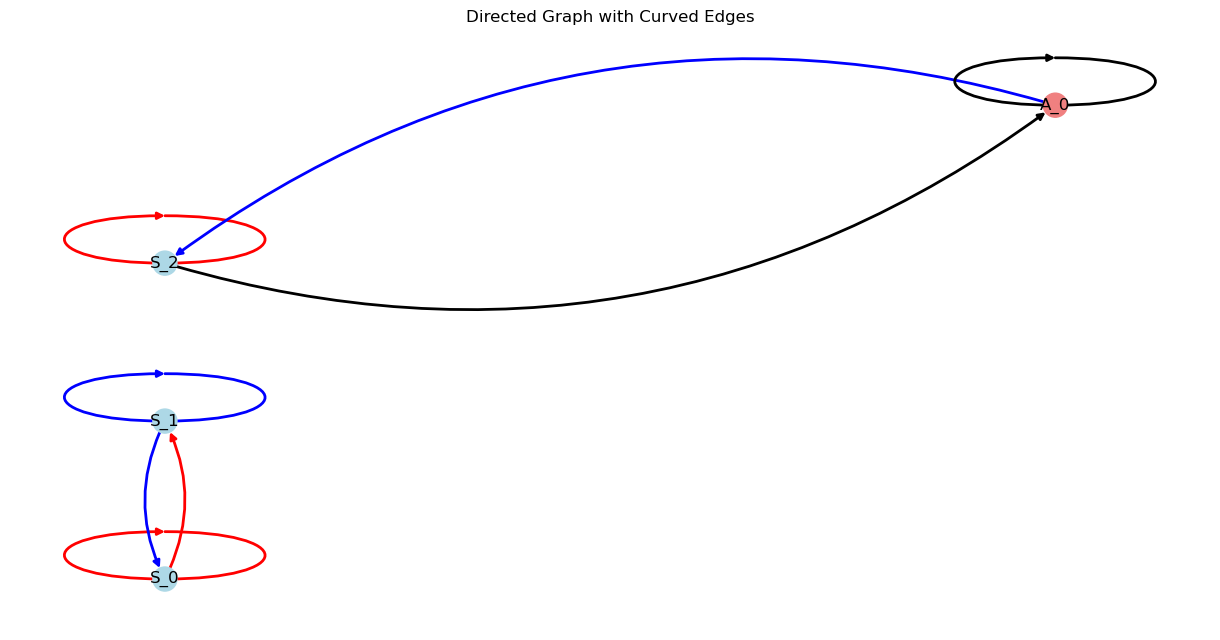

In [25]:
Draw_EPM_digraph(D)

## 위 코드들은 잘 작동함

In [26]:
def is_single_scc(graph):
    """
    Check if the graph is a single strongly connected component (SCC).

    Parameters:
        graph (nx.DiGraph): Directed graph.

    Returns:
        bool: True if the graph is a single SCC, False otherwise.
    """
    sccs = list(nx.strongly_connected_components(graph))
    return len(sccs) == 1 and len(sccs[0]) == len(graph)

def filter_groups_by_scc(grouped_graphs):
    """
    Filter groups of graphs based on whether their first element's DiGraph is a single SCC.

    Parameters:
        grouped_graphs (dict): Dictionary where each key represents a group identifier, and the value is a list of graphs.

    Returns:
        dict: Filtered dictionary containing only groups whose first graph is a single SCC.
    """
    filtered_groups = {}
    for key, group in grouped_graphs.items():
        if group:
            # Convert the first graph in the group to a DiGraph
            D = EPM_digraph_from_EPM_bipartite_graph(group[0])
            # Check if it is a single SCC
            if is_single_scc(D):
                filtered_groups[key] = group
    return filtered_groups


In [27]:
filtered_groups = filter_groups_by_scc(grouped_graphs)

In [28]:
filtered_groups

{'218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8': [<networkx.classes.graph.Graph at 0x14fa48810>,
 'a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a': [<networkx.classes.graph.Graph at 0x14fa6cd90>,
 '7959e8b9b6367ea841c063652027ca3291a2759513b05897bde6c9a55b5a0d2d': [<networkx.classes.graph.Graph at 0x14fa6ed10>,
 'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d': [<networkx.classes.graph.Graph at 0x14fa661d0>,
  ...],
 '0bd32b8e4d20824cbd28a77b586a28f3476cd8be323a986e5039a815fe05c0ac': [<networkx.classes.graph.Graph at 0x127d5fe50>,
  <networkx.classes.graph.Graph at 0x168eacb10>]}

In [29]:
def count_dict_elements(d):
    """
    Count the total number of elements in a dictionary, including keys and values.
    Parameters:
    d (dict): Input dictionary.
    Returns:
    int: Total number of elements in the dictionary.
    """
    if not isinstance(d, dict):
        raise ValueError("Input must be a dictionary.")
    
    total_elements = 0
    for key, value in d.items():
        total_elements += 1  # Count the key
        if isinstance(value, dict):  # Recursively count elements in nested dictionaries
            total_elements += count_dict_elements(value)
        elif isinstance(value, list):  # Count elements in lists
            for item in value:
                if isinstance(item, dict):
                    total_elements += count_dict_elements(item)
                else:
                    total_elements += 1
        else:
            total_elements += 1  # Count the value if not a container
    
    return total_elements


In [30]:
count_dict_elements(filtered_groups)

2693

In [31]:
list(filtered_groups.keys())[0]

'218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8'

In [32]:
len(filtered_groups[list(filtered_groups.keys())[0]])

192

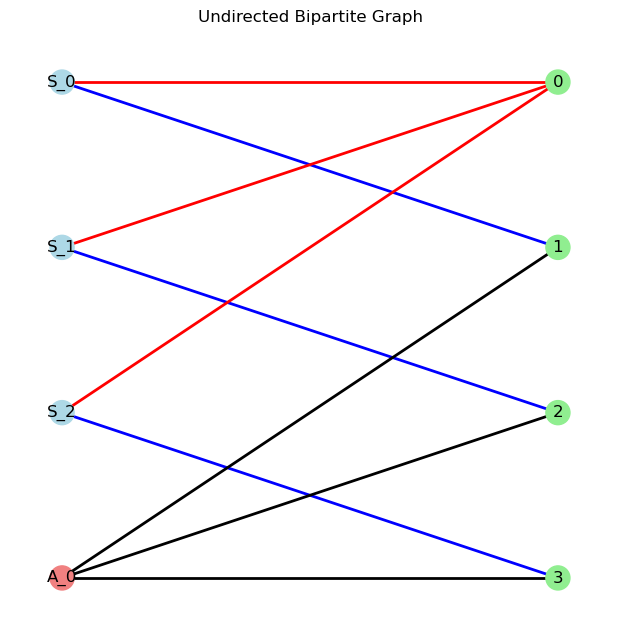

In [33]:
Draw_EPM_bipartite_graph(filtered_groups[list(filtered_groups.keys())[0]][0])

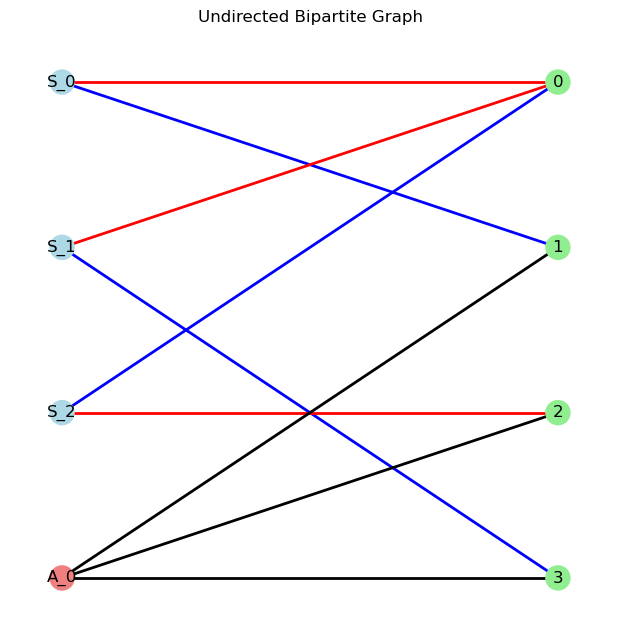

In [34]:
Draw_EPM_bipartite_graph(filtered_groups[list(filtered_groups.keys())[0]][3])

In [35]:
filtered_groups

{'218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8': [<networkx.classes.graph.Graph at 0x14fa48810>,
 'a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a': [<networkx.classes.graph.Graph at 0x14fa6cd90>,
 '7959e8b9b6367ea841c063652027ca3291a2759513b05897bde6c9a55b5a0d2d': [<networkx.classes.graph.Graph at 0x14fa6ed10>,
 'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d': [<networkx.classes.graph.Graph at 0x14fa661d0>,
  ...],
 '0bd32b8e4d20824cbd28a77b586a28f3476cd8be323a986e5039a815fe05c0ac': [<networkx.classes.graph.Graph at 0x127d5fe50>,
  <networkx.classes.graph.Graph at 0x168eacb10>]}

In [36]:
import networkx as nx

def extract_unique_bigraphs_with_weights(graph_list):
    """
    Extract unique bipartite graphs from a list, considering edge weights for isomorphism.

    Parameters:
        graph_list (list of nx.Graph): A list of bipartite graphs to process.

    Returns:
        list of nx.Graph: A list of unique bipartite graphs.
    """
    # List to store unique graphs
    unique_graphs = []

    # Define edge_match to compare edge weights
    edge_match = lambda x, y: x.get("weight", 1) == y.get("weight", 1)
    
    for new_graph in graph_list:
        # Check if the new graph is isomorphic to any existing unique graph
        is_unique = True
        for existing_graph in unique_graphs:
            if nx.is_isomorphic(new_graph, existing_graph, edge_match=edge_match):
                is_unique = False
                break

        # If unique, add to the unique_graphs list
        if is_unique:
            unique_graphs.append(new_graph)

    return unique_graphs

In [66]:
unique_graphs_list = {}

for filter_keys in filtered_groups.keys():
    unique_graphs_list[filter_keys] = extract_unique_bigraphs_with_weights(filtered_groups[filter_keys])
        

In [67]:
unique_graphs_list

{'218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8': [<networkx.classes.graph.Graph at 0x14fa48810>,
 'a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a': [<networkx.classes.graph.Graph at 0x14fa6cd90>,
 '7959e8b9b6367ea841c063652027ca3291a2759513b05897bde6c9a55b5a0d2d': [<networkx.classes.graph.Graph at 0x14fa6ed10>,
 'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d': [<networkx.classes.graph.Graph at 0x14fa661d0>,
 '0bd32b8e4d20824cbd28a77b586a28f3476cd8be323a986e5039a815fe05c0ac': [<networkx.classes.graph.Graph at 0x127d5fe50>,
  <networkx.classes.graph.Graph at 0x14faa1f50>]}

In [69]:
total_elements = sum(len(v) for v in unique_graphs_list.values())  # 모든 리스트 요소 개수 합산
print(total_elements)  # 출력: 9

24


In [65]:
unique_graphs_list[list(unique_graphs_list.keys())[3]]

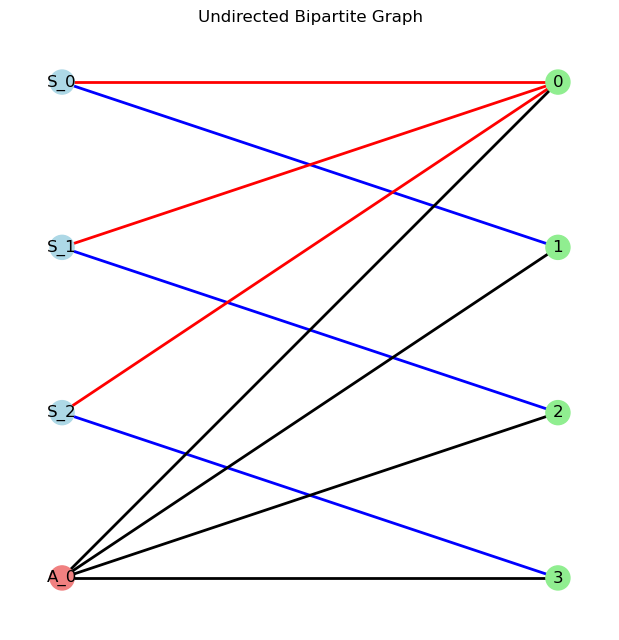

In [62]:
Draw_EPM_bipartite_graph(unique_graphs_list[list(unique_graphs_list.keys())[1]][0])

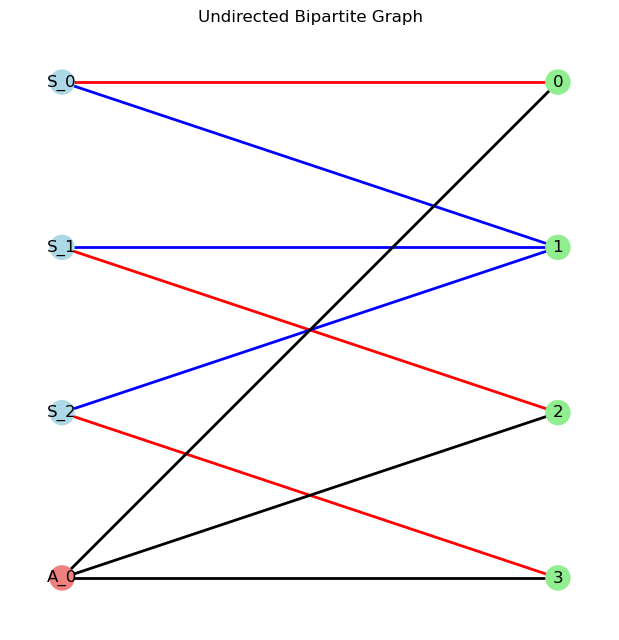

In [ ]:
Draw_EPM_bipartite_graph(unique_graphs_list[list(unique_graphs_list.keys())[0]][3])

In [ ]:
j = 0
for i in unique_graphs_list[list(unique_graphs_list.keys())[0]]:
    edge_match = lambda x, y: x.get("weight", 1) == y.get("weight", 1)
    if nx.is_isomorphic(filtered_groups[list(filtered_groups.keys())[0]][1919], i, edge_match=edge_match):
        print(j)
    j += 1


IndexError: list index out of range

In [ ]:
nx.is_isomorphic(filtered_groups[list(filtered_groups.keys())[0]][1919], unique_graphs_list[list(unique_graphs_list.keys())[0]][0], edge_match=edge_match)

IndexError: list index out of range

In [ ]:
def get_key_with_most_elements(input_dict):
    """
    Find the key with the most elements in its value and the number of elements.

    Parameters:
        input_dict (dict): A dictionary where values are iterable.

    Returns:
        tuple: A tuple containing the key with the most elements and the number of elements.
    """
    if not input_dict:
        return None, 0  # Return None if the dictionary is empty

    # Find the key with the most elements
    max_key = max(input_dict, key=lambda k: len(input_dict[k]))
    max_count = len(input_dict[max_key])

    return max_key, max_count


In [ ]:
max_key, max_count = get_key_with_most_elements(unique_graphs_list)

In [ ]:
max_count

8

In [ ]:
max_key

'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d'

In [ ]:
max_key_fil, max_count_fil = get_key_with_most_elements(filtered_groups)

In [ ]:
max_count_fil

1152

In [ ]:
max_key_group, max_count_group = get_key_with_most_elements(grouped_graphs)

In [ ]:
max_count_group

1152

In [ ]:
max_key_group

'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d'